# Transfer Learning

[![](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ganegroup/workshop_nn/blob/main/12_transfer_learning.ipynb)

Transfer learning es una técnica en donde se utiliza una red preentrenada como "feature extractor" pero esos features son utilizados para otro objetivo que no necesariamente es el mismo que para el que fue diseñada la red original. 

En el caso de clasificación esto puede servir para clasificar objetos que pueden o no haber estado en el dataset original. 

Generalmente la red original fue entrenado en un dataset muy grande y son modelos complejos y con una estrucutra muy rica, todo eso los hace funcionar muy bien como feature extractors, pero a la vez costosos de entrenar. Transfer learning es una forma de aprovechar ese entrenamiento sin necesidad de pagar el gran costo de entrenamineto. 

<!-- ![Esquema de transfer learning](images/transfer_learning.png) -->

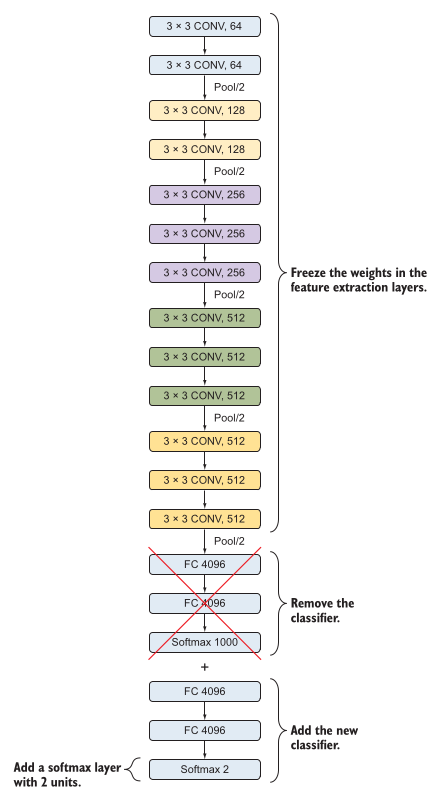

Para tareas de clasificación suele haber cuatro escenarios posibles:

- El dataset objetivo es **pequeño** y **similar** al dataset original
- El dataset objetivo es **grande** y **similar** al dataset original
- El dataset objetivo es **pequeño** y **muy diferente** al dataset original
- El dataset objetivo es **grande** y **muy diferente** al dataset original

Cada uno de estos escenarios requiere estrategias ligeramente diferentes, pero incluso en el caso de datasets objetivo grandes, suele ser conveniente hacer transfer learning antes que entrenar desde cero. 

Existen otros casos en donde se puede utilizar una red preentrenada, por ejemplo como "backbone" de otras redes que realizan tareas complejas o incluso a veces funcionan como "métricas de percepción" de la calidad de imágenes. 

In [1]:
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
sns.set_theme()

from keras.applications import VGG16

2023-07-02 17:22:05.556240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices()

2023-07-02 17:22:06.992411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:22:06.995572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:22:06.995690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras import layers

# Data loading and preprocessing

(train_data, validation_data), info = tfds.load('tf_flowers', split=["train[:75%]", "train[75%:]"], with_info=True, as_supervised=True)

num_classes = 5

def normalize(image, label):
    """ Normalize image: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def to_categorical(image, label):
    return image, tf.one_hot(tf.cast(label, tf.int32), num_classes)

def resize(image, label):
    """ Resize the image"""
    image = tf.image.resize(image, [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, label

# initiliaze the color normalization layer
normalization_layer = layers.Normalization(axis=None)
normalization_layer.adapt(train_data.map(normalize).map(lambda x, y: x))


def pipeline(dataset):
    dataset = dataset.map(normalize)
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
    dataset = dataset.map(to_categorical)
    dataset = dataset.map(resize)
    dataset = dataset.cache()
    dataset = dataset.shuffle(info.splits['train[:75%]'].num_examples)
    return dataset

processed_train_data = pipeline(train_data)
processed_validation_data = pipeline(validation_data)

batch_size = 64

batched_train_data = processed_train_data.batch(batch_size)
batched_validation_data = processed_validation_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomZoom((-0.2, 0.2)),
  layers.RandomTranslation(
    (-0.1, 0.1), (-0.1, 0.1)
  ),
  layers.RandomRotation(0.2),
])

2023-07-02 17:22:07.183488: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /home/user/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


2023-07-02 17:22:27.058776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:22:27.058938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:22:27.059038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

base_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

En la siguiente celda podemos configurar que capas van a ser entrenables y cuales no

In [5]:
for layer in base_model.layers:
    layer.trainable = False

In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.models import Model

In [8]:
last_layer = base_model.get_layer("block5_pool")
last_layer

In [9]:
last_output = last_layer.output
last_output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [10]:
x = Flatten()(last_output)

x = Dense(64, activation="leaky_relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(num_classes, activation="softmax", name="softmax")(x)

In [11]:
new_model = Model(inputs=base_model.input, outputs=x)

new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/home/user/tensorflow_datasets/tf_flowers/3.0.1.incomplete1K61PS',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [13]:
# batched_train_data = batched_train_data.map(lambda x, y: (data_augmentation(x), y))
batched_train_data = batched_train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

new_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [15]:
history = new_model.fit(
    batched_train_data,
    epochs=10,
    validation_data=batched_validation_data,
)

Epoch 1/10


2023-07-02 17:22:35.181011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]
2023-07-02 17:22:35.181318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [2]
	 [[{{node Placeholder/_4}}]]
2023-07-02 17:22:36.924651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-02 17:22:38.489246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-02 17:22:3

43/43 [==============================] - ETA: 0s - loss: 1.0551 - accuracy: 0.6661

2023-07-02 17:22:43.288914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_25' with dtype float and shape [1,1,1]
	 [[{{node Placeholder/_25}}]]
2023-07-02 17:22:43.289339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype float and shape [1,1,1]
	 [[{{node Placeholder/_24}}]]


43/43 [==============================] - 10s 164ms/step - loss: 1.0551 - accuracy: 0.6661 - val_loss: 1.5755 - val_accuracy: 0.5381
Epoch 2/10
43/43 [==============================] - 6s 147ms/step - loss: 0.4692 - accuracy: 0.8368 - val_loss: 0.9142 - val_accuracy: 0.6765
Epoch 3/10
43/43 [==============================] - 6s 137ms/step - loss: 0.3286 - accuracy: 0.8830 - val_loss: 0.5811 - val_accuracy: 0.7843
Epoch 4/10
43/43 [==============================] - 6s 137ms/step - loss: 0.2530 - accuracy: 0.9186 - val_loss: 0.4847 - val_accuracy: 0.8246
Epoch 5/10
43/43 [==============================] - 6s 141ms/step - loss: 0.2064 - accuracy: 0.9331 - val_loss: 0.4759 - val_accuracy: 0.8301
Epoch 6/10
43/43 [==============================] - 6s 142ms/step - loss: 0.1635 - accuracy: 0.9531 - val_loss: 0.4894 - val_accuracy: 0.8235
Epoch 7/10
43/43 [==============================] - 6s 140ms/step - loss: 0.1449 - accuracy: 0.9597 - val_loss: 0.4906 - val_accuracy: 0.8203
Epoch 8/10
43/43

<Axes: >

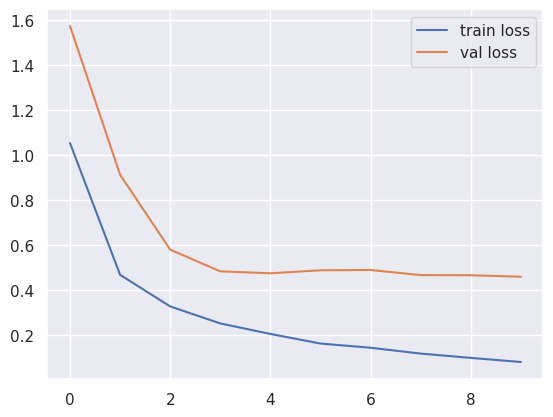

In [16]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label="train loss")
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label="val loss")

<Axes: >

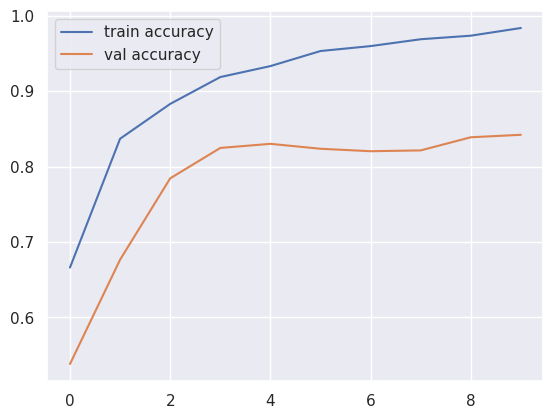

In [17]:
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label="train accuracy")
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label="val accuracy")